## _"Lingua o Dialetto?"_ Exploring Perceptions of Regional Italian Languages Over Time
#### _Alex Nisnevich_

### Introduction

Despite Italy's linguistic diversity _(see map below)_, it is commonplace within Italy to refer to regional languages as _dialetti_ rather than _lingue_.

In this notebook, I explore how perceptions of certain languages as "languages" rather than "dialects" have shifted over time in Italy, using the Google Books Ngrams dataset.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/65/Linguistic_map_of_Italy_-_Legend.svg" width="500"/>
</div>

### Data Collection

As a proxy of dialect-vs-language perception within Italian culture over time, I'm going to look at instances where given languages are described as "lingua X" or "dialetto X" in Italian published books, using the [Google Books Italian 2-grams dataset](http://storage.googleapis.com/books/ngrams/books/20200217/ita/ita-2-ngrams_exports.html). 

__*Caveats.*__ This is admittedly a rough proxy. The phrase "dialetto X" alone doesn't in all contexts imply X to be a dialect - for example, `"il triestino è un dialetto veneto"` (`"Triestine is a Venetian dialect"`) uses the phrase "dialetto veneto" without making any claim about Venetian being a dialect or a language. Similarly, "lingua X" may be used in some contexts where it doesn't, in and of itself, refer to X as a language.

In practice, at least from my casual searches through Google Books's archives, this distinction does tend to hold in most cases. To illustrate, here are two examples referencing Friulian:

* _"La massima parte delle voci che il **dialetto friulano** possiede (prescindendo da ogni questione di origine) appariscono comuni alla lingua scritta italiana" ("Most of the voices that the **Friulian dialect** possesses (regardless of any question of origin) appear common to the written Italian language")_ (Piruna, _Vocabolario friulano_, 1871)
* _“Fin dalle prime verifiche emerge che complessivamente nelle Province di Gorizia, Pordenone e Udine oltre la metà degli alunni frequentanti chiede l'insegnamento della **lingua friulana**”
(“From the initial audit it emerges that overall in the Provinces of Gorizia, Pordenone and Udine over half of the attending students ask for the **Friulian language** to be taught”)_ (Heinemann and Melchior, _Manuale di linguistica friulana_, 2015)

I downloaded the [Google Books Italian 2-grams dataset](http://storage.googleapis.com/books/ngrams/books/20200217/ita/ita-2-ngrams_exports.html) and extracted out just the 2-grams starting with either "lingua" or "dialetto":
```
cat 2-00040-of-00060 | grep "^lingua " > lingua.tsv
cat 2-00030-of-00060 | grep "^dialetto " > dialetto.tsv
```

Here's what these n-gram records look like – for each 2-gram in the dataset, its corresponding row contains a set of tab-separated `{year},{# mentions},{# distinct volumes}` tuples:

In [54]:
!head -1 dialetto.tsv

dialetto calabrese_ADJ	1821,7,7	1823,2,1	1825,4,2	1829,5,5	1830,4,3	1831,1,1	1832,3,3	1835,3,2	1836,3,3	1837,4,4	1838,4,4	1840,2,2	1841,5,5	1844,9,9	1845,4,2	1847,4,4	1848,3,3	1849,4,4	1852,10,5	1853,12,12	1854,3,3	1855,8,8	1856,4,4	1858,6,5	1861,4,4	1862,14,14	1863,7,7	1864,17,17	1865,2,1	1866,9,9	1867,4,3	1868,2,1	1869,10,10	1870,38,12	1871,32,11	1872,23,21	1874,42,33	1875,12,11	1876,6,6	1877,8,8	1878,19,9	1879,152,19	1880,74,21	1881,4,4	1882,32,15	1883,18,11	1884,7,7	1885,10,10	1886,13,10	1887,12,11	1888,56,29	1889,4,4	1890,20,18	1891,30,18	1892,27,21	1893,14,10	1894,60,34	1895,110,46	1896,12,9	1897,30,12	1898,50,29	1899,8,6	1900,29,21	1901,8,7	1902,16,12	1903,7,3	1904,8,6	1905,38,17	1906,13,13	1907,16,11	1908,28,7	1909,24,13	1910,76,20	1911,85,46	1912,2,2	1913,7,5	1914,12,6	1915,17,13	1916,25,12	1917,5,5	1918,2,2	1919,1,1	1920,7,6	1921,4,3	1922,10,6	1923,3,3	1924,20,16	1925,49,14	1926,19,10	1927,7,6	1928,89,19	1929,20,16	1930,33,26	1931,31,14	1932,34,17	1933,20,17	1934,10,10	1935,3

Now let's load the data within:

In [46]:
%%capture
!pip3 install matplotlib pandas scipy #scikit-learn

In [97]:
import csv
import datetime as dt

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gmean

Some entries in the corpus appear to be tagged with parts of speech (starting with an underscore) and some aren't (e.g. there are seaprate entries for `dialetto friulano` and `dialetto friulano_ADJ`. Let's merge these together when we read from these TSV files:

In [98]:
def read_from_tsv(filename):
    dict = {}
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            lang = row[0].split('_')[0]
            
            if lang not in dict:
                dict[lang] = {}
            
            for count in row[1:]:
                (year, counts, volumes) = [int(x) for x in count.split(',')]
                if year not in dict[lang]:
                    dict[lang][year] = { 'counts': 0, 'volumes': 0 }
                dict[lang][year]['counts'] += counts
                dict[lang][year]['volumes'] += volumes
    return dict

In [99]:
DIALETTO = read_from_tsv('dialetto.tsv')
LINGUA = read_from_tsv('lingua.tsv')

### Computing "dialetto" vs "lingua" scores

We've ingested the data – now let's do something with it!

Here are the languages we're going to explore. I'm limiting us specifically to regional Romance varieties spoken within Italy (though some are spoken in Italy only in border areas).

In [100]:
# corresponding feminine and masculine forms ("lingua" is feminine, "dialetto" is masculine)
LANGUAGES = [
    # Insular
    ('sarda', 'sardo'),
    ('corsa', 'corso'),
    # ('sassarese', 'sassarese'),   # no mentions of "dialetto sassarese" in the dataset
    ('gallurese', 'gallurese'),

    # Gallo-Italic (I'll include Venetian here as well)
    ('ligure', 'ligure'),
    ('piemontese', 'piemontese'),
    ('lombarda', 'lombardo'),
    ('emiliana', 'emiliano'),
    ('romagnola', 'romagnolo'),
    ('veneta', 'veneto'),

    # Rhaeto-Romance
    ('friulana', 'friulano'),
    ('ladina', 'ladino'),

    # Southern Italian
    ('napoletana', 'napoletano'),
    ('siciliana', 'siciliano'),
    
    # other Romance
    ('occitana', 'occitano'),
    ('catalana', 'catalano'),
    ('francoprovenzale', 'francoprovenzale')
]

Because we are given both the number of individual mentions and the number of separate books that each phrase is mentioned in, we have to decide how to "score" phrases. It feels unfair to use only one of the two counts, so I'm going to incorporate both of them by taking the _geometric mean_ of the `(# mentions)` and `(# volumes)`. So, for example, 1 book with 9 separate mentions of `"dialetto X"` in a given year would give X `sqrt(1 * 9) = 3` "dialetto points".

In [101]:
def count_score(num_mentions, num_volumes):
    #return num_mentions
    #return num_volumes
    # let's take the geometric mean of (# mentions) and (# volumes), so, for example, 1 book with 9 separate mentions counts as "3 points"
    return gmean([num_mentions, num_volumes])  

What we're really interested in is the ratio of the usage of "lingua X" versus "dialetto X" for each language, over time. So now all we have to do is divide each language's "lingua points" over its "dialetto points" over time, right?

It's not quite so simple. The problem is that our data is still fairly spotty and peaky as-is – for the average language, there are going to be many years in the dataset with no records at all, or just one record. So we need to clean things up a little:

* First, let's take a 10-year rolling average for both the "lingua points" and "dialetto points" (to help fill in gaps in the record)
* Then, let's clamp the `(lingua points)/(dialetto points)` results to the `[0.01, 100]` range (this helps the graphs not go crazy when either score is `0` or very close to `0` in a given year)
* Finally, to avoid crazy jitter when graphing these, we're also going to keep track of total points (`lingua points + dialetto points`) for each language over time, and either hide or mark portions of the graph when there's just not enough data. Somewhat arbitrarily, I chose `1.5` points as the threshold under which to hide the line in the graph graph, and `10` points as the threshold under which to dash to the line being drawn.
In other words,
  * `>10` total points = solid line
  * `>1.5` but `≤10` total points = dashed line
  * `≤1.5` total points = no line

In [237]:
HIDDEN_POINTS_THRESHOLD = 1.5
DASHED_POINTS_THRESHOLD = 10

Ok, with all that in mind, let's compute some ratios:

In [238]:
def compute_ratios_over_time_df():
    ratios_df = pd.DataFrame()
    total_points_df = pd.DataFrame()
    
    for (fem, masc) in LANGUAGES:
        s_d = pd.DataFrame.from_dict([{'year': k, 'dialetto': count_score(v['counts'], v['volumes'])} for k, v in DIALETTO['dialetto ' + masc].items()])
        s_l = pd.DataFrame.from_dict([{'year': k, 'lingua': count_score(v['counts'], v['volumes'])} for k, v in LINGUA['lingua ' + fem].items()])
        s = s_d.merge(s_l, on='year', how='outer', sort=True).fillna(0)
        
        s['year'] = pd.to_datetime(s['year'], format='%Y', errors = 'coerce')
        s.set_index(s['year'], inplace=True)
        s = s.drop(columns=['year'])
        s = s.resample('Y').sum().fillna(0)

        # since there's a lot of years with no data, compute a rolling score over 10 years at a time
        s['dialetto_rolling'] = s['dialetto'].rolling(10, min_periods=1).mean()
        s['lingua_rolling'] = s['lingua'].rolling(10, min_periods=1).mean()

        total_points_series = s['dialetto_rolling'] + s['lingua_rolling']
        
        # ignore years (i.e. mark as NaN) where the sum of `dialetto` points and `lingua` points is ≤HIDDEN_POINTS_THRESHOLD (this avoids jitter in the graphs)
        s['lingua_over_dialetto'] = np.where(
            total_points_series > HIDDEN_POINTS_THRESHOLD, 
            # otherwise, divide (lingua points / dialetto points), clamping the result in the [10^-2, 10^2] range (to avoid graph artifacts from NaNs and Infs)
            np.clip(s['lingua_rolling'] / np.maximum(s['dialetto_rolling'], 0.01), 0.01, 100),
            np.nan
        )

        total_points_df[masc] = total_points_series
        ratios_df[masc] = s['lingua_over_dialetto']

    # sort the columns by the most recent value, descending (this will make the graph legend easier to reference)
    languages_sorted_by_last_value = list(ratios_df[-1:].transpose().sort_values(by=ratios_df[-1:].transpose().columns[0], ascending=False).index)    
    ratios_df = ratios_df[languages_sorted_by_last_value]
    return (ratios_df, total_points_df)

In [239]:
(ratios_df, total_points_df) = compute_ratios_over_time_df()

Here's what our results look like, starting with the most recent years in the corpus:

In [332]:
#pd.set_option('display.max_rows', 500)
ratios_df[::-1][:10]

,ladino,catalano,sardo,occitano,friulano,francoprovenzale,corso,gallurese,napoletano,siciliano,piemontese,veneto,lombardo,ligure,romagnolo,emiliano
year,,,,,,,,,,,,,,,,
2019-12-31,23.906890,8.417445,3.397414,2.967767,1.945745,1.414540,0.938032,0.501046,0.341950,0.208703,0.200098,0.183560,0.124801,0.103877,0.064726,0.029644
2018-12-31,19.366317,8.740618,3.556526,2.969288,1.812227,1.388631,0.974684,0.482339,0.315119,0.204900,0.186516,0.175364,0.129751,0.108192,0.061206,0.028789
2017-12-31,11.876095,8.435152,3.355716,3.147616,1.736623,1.212346,1.032273,0.439949,0.291326,0.199951,0.189482,0.169451,0.131547,0.117143,0.070209,0.028789
2016-12-31,7.602609,8.391169,3.140727,3.307540,1.526633,1.453053,0.939851,0.265141,0.292915,0.195641,0.184241,0.167842,0.161374,0.126578,0.086516,0.027983
2015-12-31,6.345439,10.066546,3.543977,3.326275,1.434849,1.274169,0.948266,0.329044,0.264673,0.202892,0.200479,0.155749,0.175458,0.121912,0.109362,0.033985
2014-12-31,5.282704,14.309906,3.861320,3.572669,1.044925,1.138002,1.098636,0.379135,0.259421,0.199110,0.206823,0.156655,0.198118,0.086616,0.108494,0.034498
2013-12-31,4.950201,13.595924,4.065698,3.804810,1.105768,0.678121,1.109242,0.476477,0.264284,0.195723,0.223015,0.150364,0.211927,0.079489,0.101292,0.059365
2012-12-31,4.370873,13.992523,4.698930,4.545550,1.253029,0.848049,1.618677,0.369246,0.270262,0.197060,0.233513,0.167488,0.214008,0.090818,0.098607,0.096564
2011-12-31,4.077952,13.458426,4.791814,4.091816,1.269453,1.018049,2.030821,0.313035,0.253672,0.209354,0.264230,0.159488,0.245370,0.084318,0.093631,0.104425


### Let's plot it!

A table is hard to visualize – let's throw it all into a plot! 

Note that from here on out, everything's going to be in log-space – it seems like the right call given that we're dealing with ratios here.

First, let's just plot everything we've got, all in one graph:

In [241]:
def plot_series_semidashed(ax, series, points_series, label=None, **kwargs):
    """Plot a series on an axis as a solid line when the points_series is above DASHED_POINTS_THRESHOLD, and as a dashed line otherwise."""
    idx = series.index
    points_series_reindexed = points_series[points_series.index.isin(idx)]
    
    line, = ax.semilogy(idx, np.where(points_series_reindexed > DASHED_POINTS_THRESHOLD, series, np.nan), label=label, **kwargs)
    ax.semilogy(idx, np.where(points_series_reindexed <= DASHED_POINTS_THRESHOLD, series, np.nan), '--', color=line.get_color(), **kwargs)

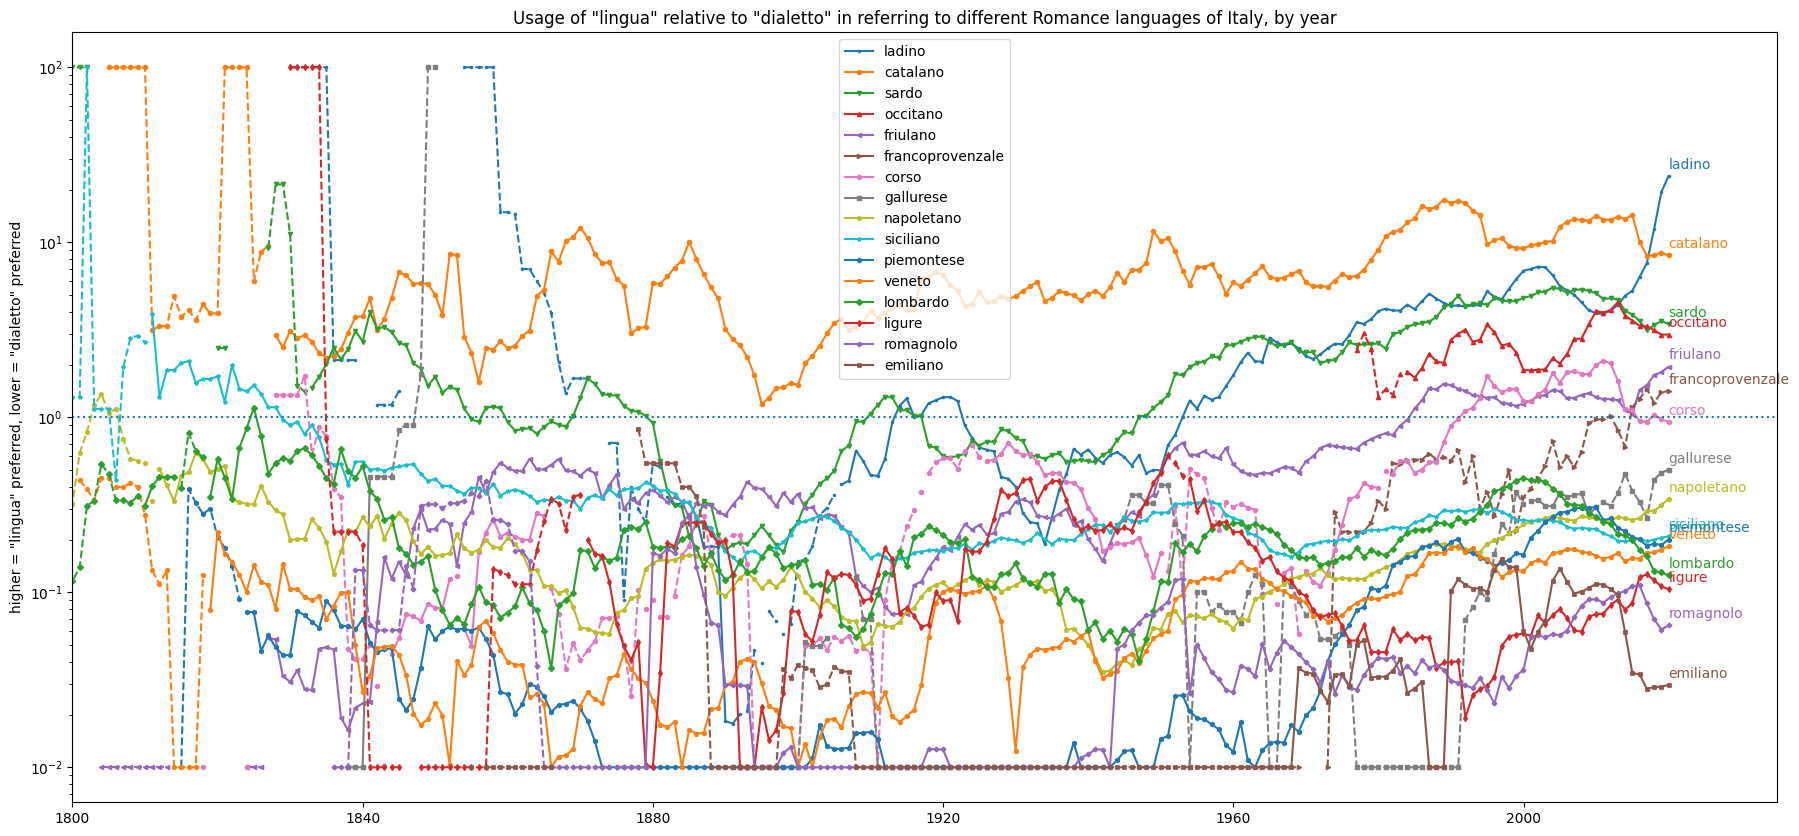

In [242]:
fig, ax = plt.subplots(figsize=(22, 10))
ax.set_title('Usage of \"lingua\" relative to \"dialetto\" in referring to different Romance languages of Italy, by year')

ax.set_xlim(left=dt.date(1800, 1, 1), right=dt.date(2035, 1, 1))
ax.set_ylabel("higher = \"lingua\" preferred, lower = \"dialetto\" preferred")

for i, (l, y) in enumerate(ratios_df[-1:].to_dict('records')[0].items()):
    plot_series_semidashed(ax, ratios_df[l], total_points_df[l], label=l, marker=Line2D.filled_markers[i], markersize=3)
    plt.text(ratios_df[-1:].index[0], y * 1.1, l, color=[line.get_color() for line in ax.lines if line.get_label() == l][0])

ax.axhline(y=1, linestyle=':')
_ = ax.legend()

Well, we can see some patterns (some languages definitely have different trajectories than others), but overall it's kind of a mess to look at.

Instead of dropping it all in one big plot, let's try separating by language group, to see in particular if different groups have broadly different paths.

In [243]:
def it(str):
    """Helper method to italicize text in a matplotlib figure."""
    return ' '.join(['$\it{'+i+'}$' for i in str.split(' ')])

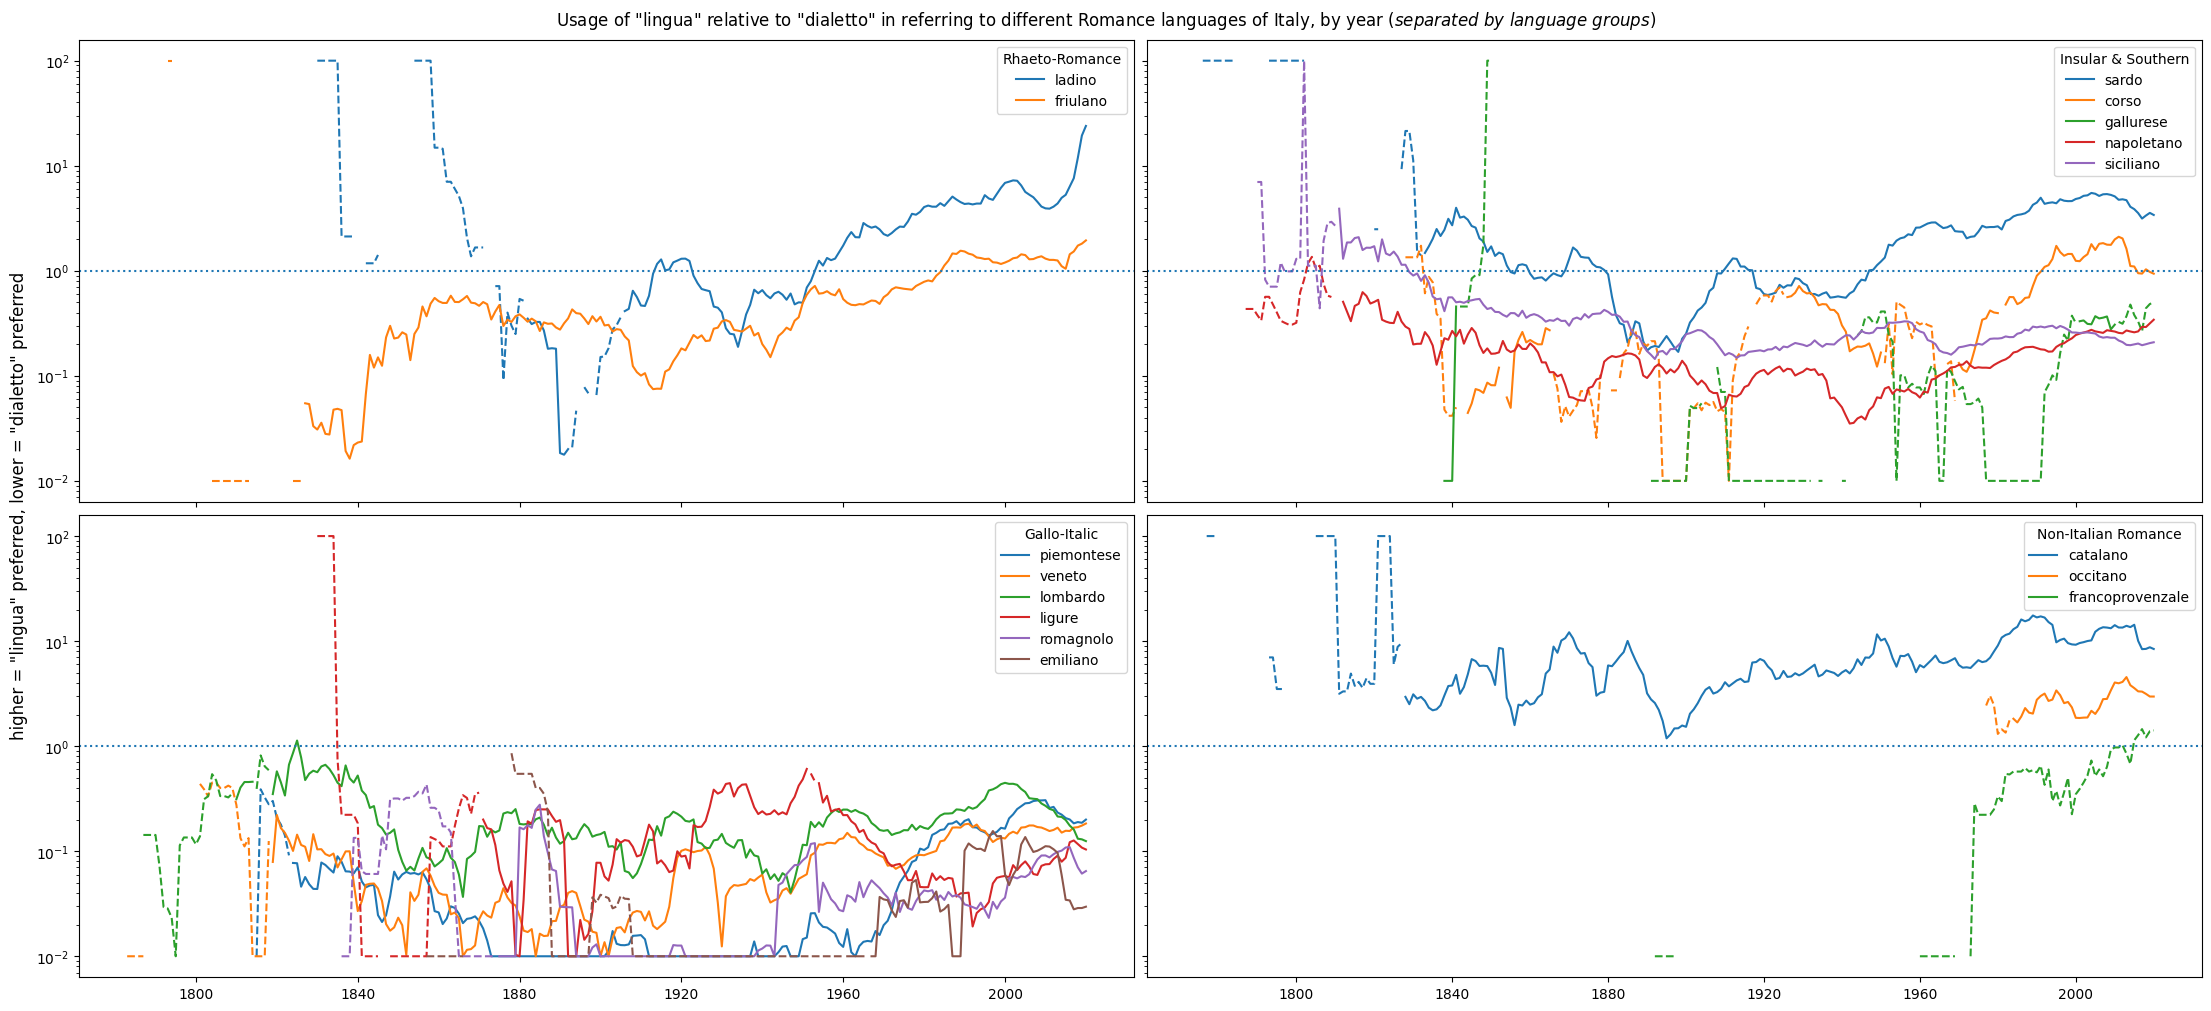

In [244]:
fig = plt.figure(figsize=(22, 10), layout='constrained')
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Usage of \"lingua\" relative to \"dialetto\" in referring to different Romance languages of Italy, by year ' + it('(separated by language groups)'))
fig.supylabel("higher = \"lingua\" preferred, lower = \"dialetto\" preferred")

def plot_languages_on_axis(ax, title, langs):
    for i, (l, y) in enumerate((l, y) for (l, y) in ratios_df[-1:].to_dict('records')[0].items() if l in langs):
        plot_series_semidashed(ax, ratios_df[l], total_points_df[l], l)
    ax.axhline(y=1, linestyle=':')
    ax.legend(title=title)

plot_languages_on_axis(ax1, 'Rhaeto-Romance', ['friulano', 'ladino'])
plot_languages_on_axis(ax2, 'Insular & Southern', ['sardo', 'corso', 'gallurese', 'siciliano', 'napoletano'])
plot_languages_on_axis(ax3, 'Gallo-Italic', ['veneto', 'piemontese', 'lombardo', 'ligure', 'romagnolo', 'emiliano'])
plot_languages_on_axis(ax4, 'Non-Italian Romance', ['catalano', 'occitano', 'francoprovenzale'])

Each language group seems to tell a slightly different story.

* The **Rhaeto-Romance** languages have broadly improved their recognition as languages over the 20th century, with the Ladino language now having the highest ratio of the bunch.
* **Sardinian** has tended to have a >1 score all throughout, aside from a dip in the late 19th century.
* The **Southern Italian** languages have either stayed level or even dropped their ratio over the course of the 19th and 20th century – Sicilian's fall is especially noticeable.
* The **Gallo-Italic** languages have consistently had a poor ratio, with no clear trend as a whole.
* Among the border languages, the **Occitano-Romance** languages (Occitan and Catalan) have consistently stayed above the >1 line. **Francoprovençal** (aka Arpitan) seems to be improving its ratio over the past few decades, though data on it is limited.

We can also plot polynomial regression curves for each graph, though the trajectory of these curves should be taken with quite a grain of salt.

In [245]:
def poly_regression(series, degree, start_dt=dt.datetime(1800, 1, 1)):
    """Given a series, produce a new series corresponding to an N-degree polynomial regression in log-space."""
    idx = series.index[series.index >= start_dt]
    values = series.iloc[series.index >= start_dt]
    idx_num = pd.to_numeric(idx)
    i = np.isfinite(values)
    poly = np.poly1d(np.polyfit(idx_num[i], np.log(values[i]), degree))
    return pd.Series(np.exp(poly(idx_num[i])), pd.to_datetime(idx_num[i]))

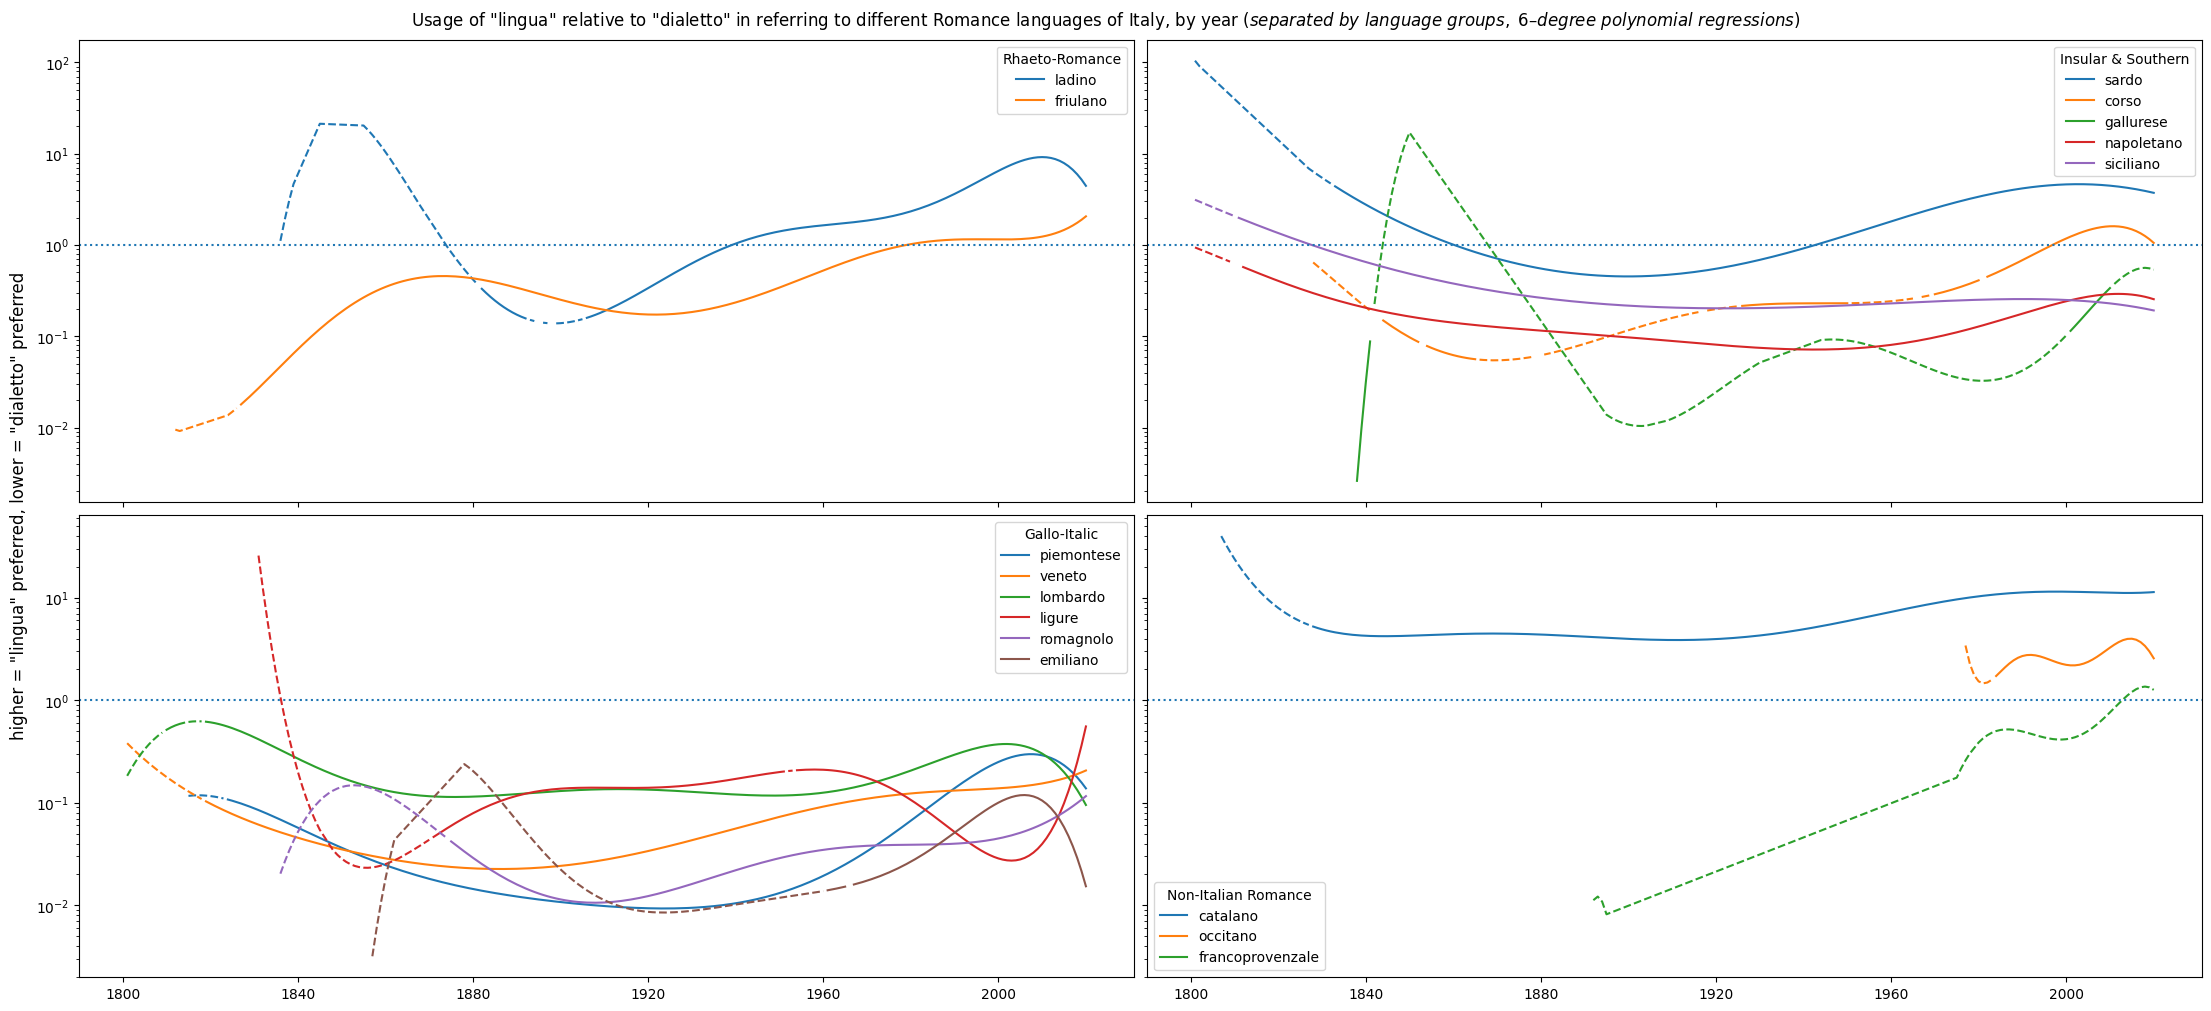

In [236]:
fig = plt.figure(figsize=(22, 10), layout='constrained')
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Usage of \"lingua\" relative to \"dialetto\" in referring to different Romance languages of Italy, by year ' + it('(separated by language groups, 6–degree polynomial regressions)'))
fig.supylabel("higher = \"lingua\" preferred, lower = \"dialetto\" preferred")

def plot_languages_on_axis(ax, title, langs):
    for i, (l, y) in enumerate((l, y) for (l, y) in ratios_df[-1:].to_dict('records')[0].items() if l in langs):
        reg = poly_regression(ratios_df[l], 6)
        plot_series_semidashed(ax, reg, total_points_df[l], l)
    ax.axhline(y=1, linestyle=':')
    ax.legend(title=title) # ax.legend(title=title + print_poly(poly))  # see https://codereview.stackexchange.com/a/54649

plot_languages_on_axis(ax1, 'Rhaeto-Romance', ['friulano', 'ladino'])
plot_languages_on_axis(ax2, 'Insular & Southern', ['sardo', 'corso', 'gallurese', 'siciliano', 'napoletano'])
plot_languages_on_axis(ax3, 'Gallo-Italic', ['veneto', 'piemontese', 'lombardo', 'ligure', 'romagnolo', 'emiliano'])
plot_languages_on_axis(ax4, 'Non-Italian Romance', ['catalano', 'occitano', 'francoprovenzale'])

### What about broader trends?

Let's take a step back and see what the broader cross-language trends are on usage of `dialetto X` vs `lingua X` over time (for all of the languages that we are interested in).

I'll take the arithmetic mean in log-space of all the `lingua/dialetto` ratios across languages.

In [139]:
# mean_by_year = ratios_df.transpose().mean()
mean_by_year = ratios_df.transpose().apply(np.log).mean().apply(np.exp) # apply arithmetic mean in log-space
mean_by_year_reg = poly_regression(mean_by_year, degree=3)

mean_total_points_by_year = total_points_df.transpose().mean()

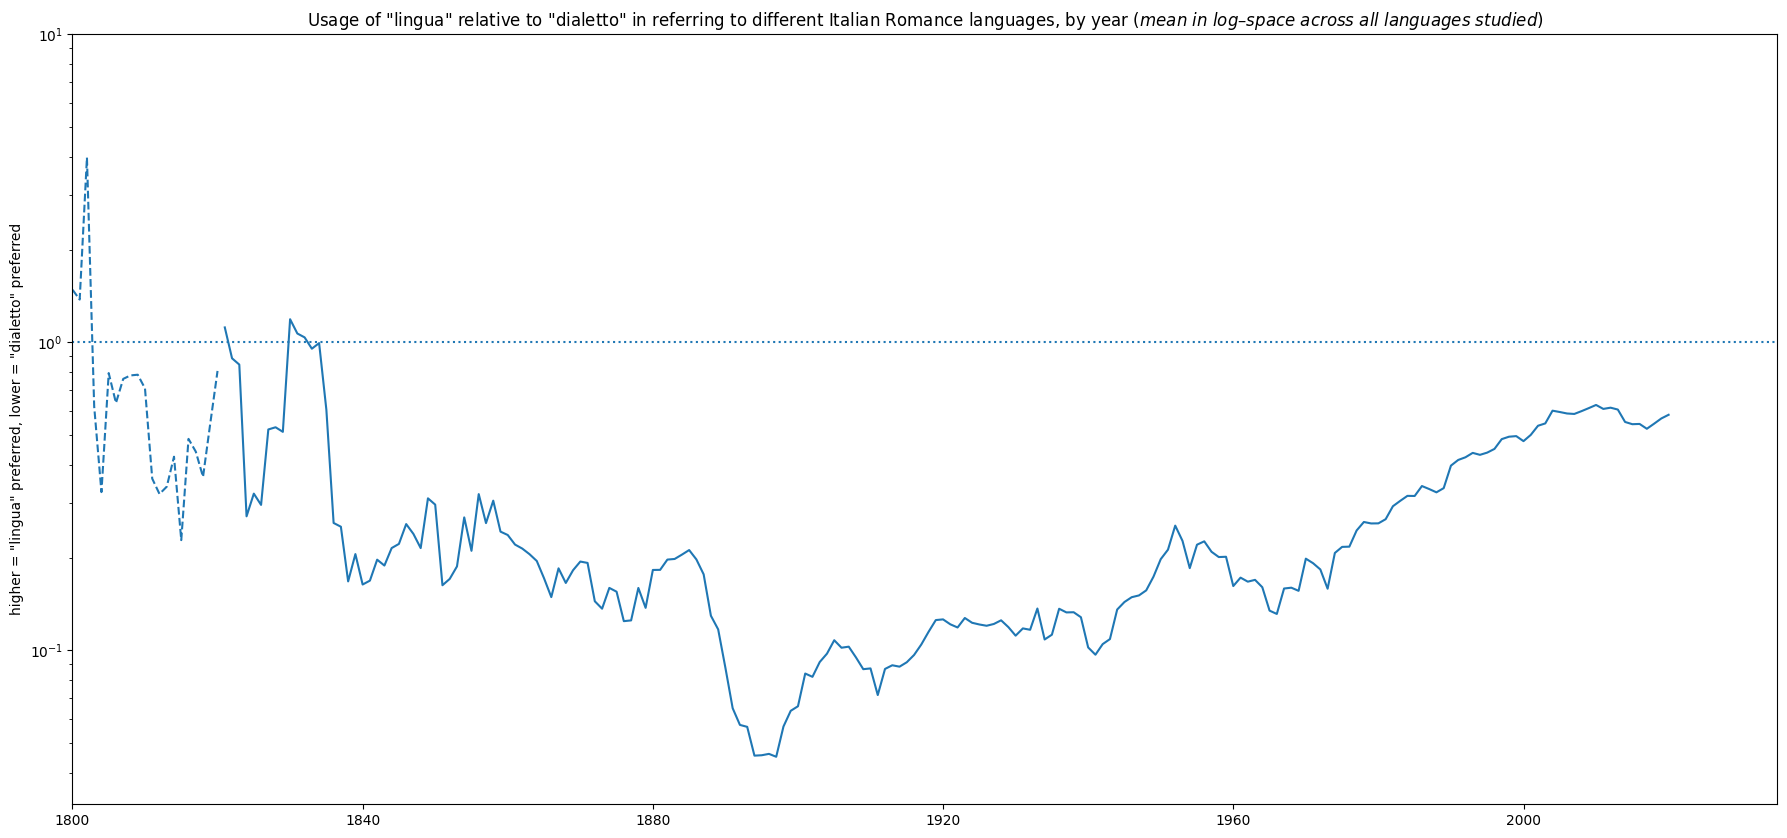

In [138]:
fig, ax = plt.subplots(figsize=(22, 10))
ax.set_title('Usage of \"lingua\" relative to \"dialetto\" in referring to different Romance languages of Italy, by year ' + it('(mean in log–space across all languages studied)'))

ax.set_xlim(left=dt.date(1800, 1, 1), right=dt.date(2035, 1, 1))
ax.set_ylim(bottom=pow(10, -1.5), top=pow(10, 1))
ax.set_ylabel("higher = \"lingua\" preferred, lower = \"dialetto\" preferred")

plot_series_semidashed(ax, mean_by_year, mean_total_points_by_year)
# plot_series_semidashed(ax, mean_by_year_reg, mean_total_points_by_year, label="cubic regression curve")

_ = ax.axhline(y=1, linestyle=':')

There's definitely a visible pattern here! We can see a precipitous decline in the use of "lingua" to describe regional languages from around ~1840 to around ~1900, neatly covering the era of Italian reunification (1848–1871, but arguably continuing through WWI, so into the mid-1910s). And there's been a slow but more-or-less steady rise in the use of "lingua" ever since, a rise that, if I squint, seems to have accelerated after the end of fascism (1945) and the founding of the Italian Republic (1946).

### Mutual intelligibility as a factor?

Why are some Italian regional language now commonly referred to as "lingue" (Ladin, Friulian, Sardinian, etc), while others remain stuck as "dialetti" (e.g. all of the Gallo-Italic languages)?

One reasonable factor to look at is _mutual intelligibility_. I would expect the average Italian to be more likely to refer to regional variety X as a "dialetto" of Italian if X seemed notably "similar" to Standard Italian (for some definition of "similar").

It's proven difficult to find mutual-intelligibility scores for the various regional languages of Italy. The best I can find is "cognancy" scores in the [Romance section of the Global Lexicostatistical Database](https://starlingdb.org/cgi-bin/response.cgi?root=new100&morpho=0&basename=new100\ier\rom&limit=-1). 

To assemble the scores below, I used the "lexicostatistical matrix" feature of the GLD using all default parameters, except setting "Ignore cognation indexes and rely on phonetic similarity instead" to true (this seemed to produce a much more reasonable-looking tree, so I would expect the congnancy scores produced to also be more reasonable with this setting on). I then took each lanaguages' cognancy score with "Standard Italian". For the languages that had multiple entries in the database, I simply averaged together their scores (which in any case tended to be very close together).

In [118]:
intelligibility_scores = pd.Series({
    "sardo": 0.52,
    # There is no Corsican data in the GLD, so I am using Grosetto Tuscan as a proxy, due to heavy Tuscan influence on Corsican.
    # This is almost certainly an overestimation of Corsican<->Standard Italian lexical similarity.
    "corso": 0.89,
    "ligure": 0.69,
    "piemontese": 0.77,
    "lombardo": 0.64,
    "emiliano": 0.79,
    "romagnolo": 0.73,
    "veneto": 0.77,
    "friulano": 0.72,
    "ladino": 0.64,
    "napoletano": 0.74,
    "siciliano": 0.68,
    "occitano": 0.57,
    "catalano": 0.55,
    "francoprovenzale": 0.33
})

As we plot these cognancy scores against the most recent lingua/dialetto ratio (circa 2019, as that's the last year in the Google Books corpus I used), it's clear that there's a fairly strong negative correlation – as we'd expect! In other words, the closer that a language is to Standard Italian, the more likely it is to be called a "dialetto" rather than a "lingua".

log y = -6.741 x + 3.975 (mean square log error = 2.684382520822006)


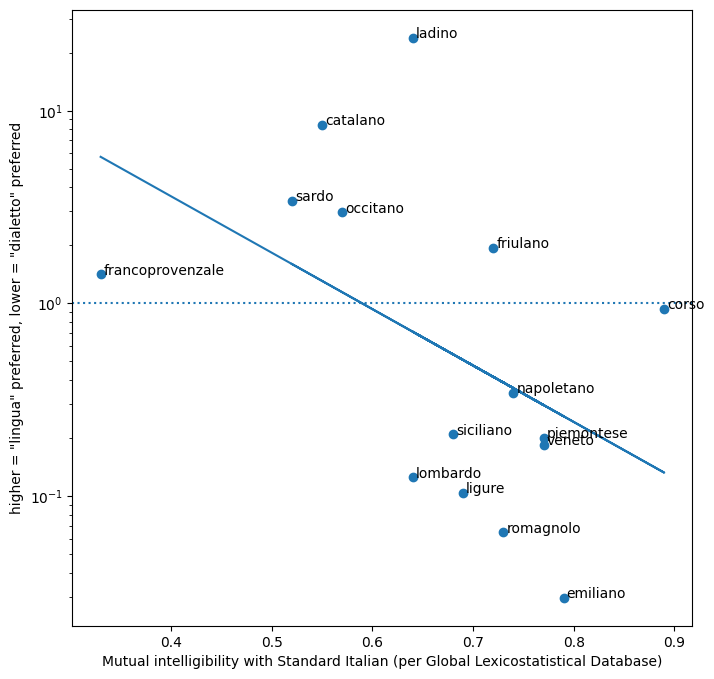

In [218]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yscale("log")
ax.axhline(y=1, linestyle=':')
ax.set_ylabel("higher = \"lingua\" preferred, lower = \"dialetto\" preferred")
ax.set_xlabel("Mutual intelligibility with Standard Italian (per Global Lexicostatistical Database)")

x = intelligibility_scores
y = ratios_df[::-1].iloc[0][intelligibility_scores.index]

ax.scatter(x, y)
for l in intelligibility_scores.index:
    ax.annotate(l, (x[l] + 0.003, y[l]))

best_fit_line = np.poly1d(np.polyfit(x, np.log(y), 1))
MSE = np.mean(np.square(best_fit_line(x) - np.log(y)))
print('log y = ' + str(best_fit_line).strip() + ' (mean square log error = ' + str(MSE) + ')')
_ = ax.plot(x, np.exp(np.poly1d(best_fit_line)(x)))

The effect is significantly more pronounced when we exclude languages mostly spoken outside of Italy (Occitan, Catalan, Franco-Provençal, and Corsican):

log y = -14.81 x + 9.311 (mean square log error = 2.2791855349824695)


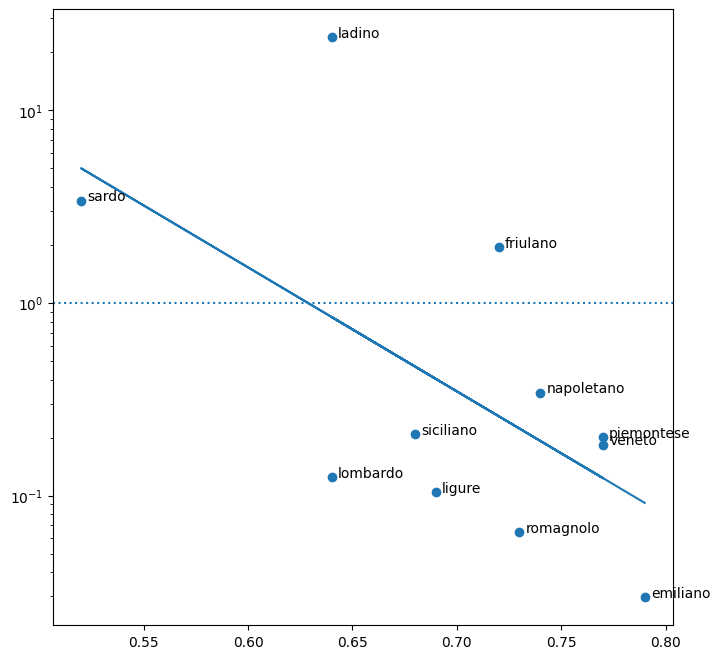

In [217]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yscale("log")
ax.axhline(y=1, linestyle=':')

LANGUAGES_TO_EXCLUDE = ['occitano', 'catalano', 'francoprovenzale', 'corso']
idx = intelligibility_scores.index.difference(LANGUAGES_TO_EXCLUDE)
x = intelligibility_scores[idx]
y = ratios_df[::-1].iloc[0][idx]

ax.scatter(x, y)
for l in idx:
    ax.annotate(l, (x[l] + 0.003, y[l]))

best_fit_line = np.poly1d(np.polyfit(x, np.log(y), 1))
MSE = np.mean(np.square(best_fit_line(x) - np.log(y)))
print('log y = ' + str(best_fit_line).strip() + ' (mean square log error = ' + str(MSE) + ')')
_ = ax.plot(x, np.exp(np.poly1d(best_fit_line)(x)))

Let's break it down by language groups again (I'll bring Corsican back just so Sardinian isn't alone in this graph, though take the position of the Corsican dot with a heavy grain of salt):

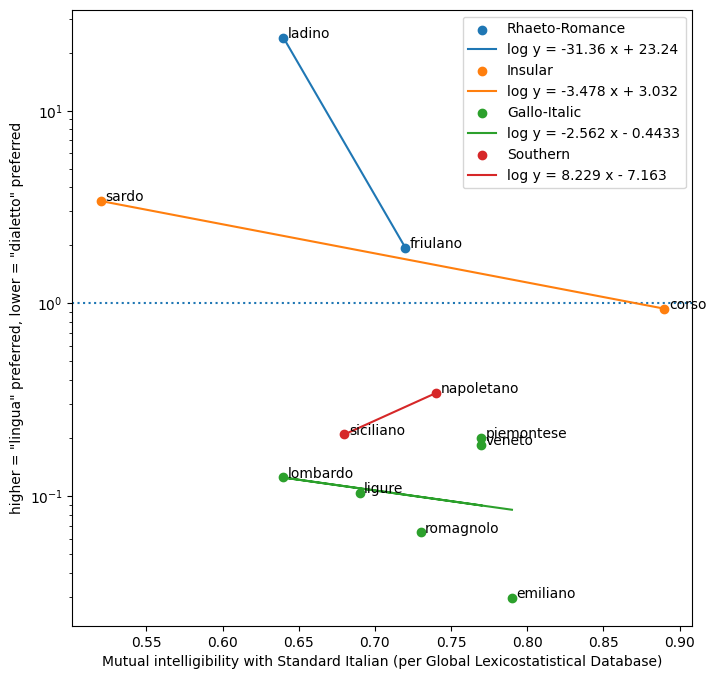

In [121]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yscale("log")
ax.axhline(y=1, linestyle=':')
ax.set_ylabel("higher = \"lingua\" preferred, lower = \"dialetto\" preferred")
ax.set_xlabel("Mutual intelligibility with Standard Italian (per Global Lexicostatistical Database)")

def plot_languages(label, languages): 
    idx = languages
    x = intelligibility_scores[idx]
    y = ratios_df[::-1].iloc[0][idx]
    
    ax.scatter(x, y, label=label)
    for l in idx:
        ax.annotate(l, (x[l] + 0.003, y[l]))
    
    best_fit_line = np.poly1d(np.polyfit(x, np.log(y), 1))
    ax.plot(x, np.exp(np.poly1d(best_fit_line)(x)), label='log y = ' + str(best_fit_line).strip())

plot_languages('Rhaeto-Romance', ['friulano', 'ladino'])
plot_languages('Insular', ['sardo', 'corso'])
plot_languages('Gallo-Italic', ['veneto', 'piemontese', 'lombardo', 'ligure', 'romagnolo', 'emiliano'])
plot_languages('Southern', ['siciliano', 'napoletano'])
_ = ax.legend()

The general trend holds across all sub-groups of languages except Southern Italian, in which Neapolitan, despite being closer to Standard Italian than Sicilian is, tends to be called a _lingua_ more often than Sicilian does (at least since circa ~2000, looking at the graphs in the previous section). I suspect there may be cultural factors at play here.

Also, looking at the Gallo-Italic group, it appears that Piedmontese and Venetian have unusually high "language cred" for their group, while Emilian appears to have unusually low "language cred".

Of course, it's clear that mutual intelligibility isn't the whole story. After all, the different language groups have very different regression lines. Friulian appears to be more mutually intelligible with Standard Italian _(at least by the metric I used, which could be faulty)_ than Sicilian, Lombard, or Ligurian, yet is _much_ more commonly referred to as a _lingua_ than any of the latter.

Politics are almost certainly at play here. After all, it can't be a coincidence that the only autochthonous regional languages with `lingua > dialetto` today are Sardinian, Ladin, and Friulian – _exactly_ the three languages in this set that are [recognized by the Italian government](https://en.wikipedia.org/wiki/Languages_of_Italy#Recognition_by_the_Italian_state).

### Official recognition as a factor?

Actually, let's try comparing each language's `lingua/dialetto` ratio to a measure of how officially recognized the language is today in Italy. I'm going to go off of [Wikipedia's list of languages of Italy](https://en.wikipedia.org/wiki/Languages_of_Italy#Regional_recognition_of_the_local_languages) and, entirely arbitrarily, assign languages 1 full point for recognition at the national level (i.e. mention in Law no. 482/1999) and 1/4 point for recognition at the regional level only. (My gut says that national-level recognition ought to be about 4x more important than regional-level recognition.)

In [224]:
recognition_scores = pd.Series({
    "sardo": 1,
    "ligure": 0,
    "piemontese": 0.25,
    "lombardo": 0.25,
    "emiliano": 0,
    "romagnolo": 0,
    "veneto": 0.25,
    "friulano": 1,
    "ladino": 1,
    "napoletano": 0,
    "siciliano": 0.25
})

Not the most exciting data series, but what happens if we plot `lingua/dialetto` ratio versus "recognition score"?

log y = 4.177 x - 2.563 (mean square log error = 0.6451349045548312)


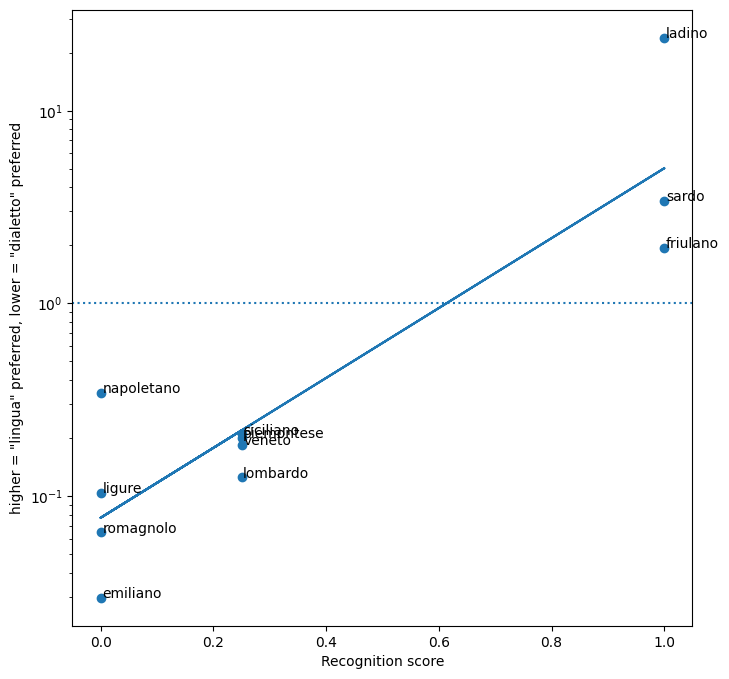

In [225]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yscale("log")
ax.axhline(y=1, linestyle=':')
ax.set_ylabel("higher = \"lingua\" preferred, lower = \"dialetto\" preferred")
ax.set_xlabel("Recognition score")

x = recognition_scores
y = ratios_df[::-1].iloc[0][recognition_scores.index]

ax.scatter(x, y)
for l in recognition_scores.index:
    ax.annotate(l, (x[l] + 0.003, y[l]))

best_fit_line = np.poly1d(np.polyfit(x, np.log(y), 1))
MSE = np.mean(np.square(best_fit_line(x) - np.log(y)))
print('log y = ' + str(best_fit_line).strip() + ' (mean square log error = ' + str(MSE) + ')')
_ = ax.plot(x, np.exp(np.poly1d(best_fit_line)(x)))

Well, then. I'm not sure if I should be surprised or not, but this janky "recognition score" actually seems to do a significantly better job of explaining the `lingua/dialetto` ratio than the quasi-scientific mutual-intelligibility score!

Actually, we can probably fit our data even better through some linear combination of the recognition score and the similarity score variables.

Let's do some linear algebra to find the coefficients for the best-fitting line `f(x1, x2) = a•x1 + b•x2 + c ≈ log y`, where `x1` is the recognition score, `x2` is the intelligibility score, and `y` is the `lingua/dialetto` ratio:

In [325]:
x1 = recognition_scores
x2 = intelligibility_scores[recognition_scores.index]
y = ratios_df[::-1].iloc[0][recognition_scores.index]

# We're solving Ax = B
A = np.column_stack([x1, x2, np.ones(len(x))])
B = np.log(y)

# Solve the system of equations.
result, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
a, b, c = result
print(f"log y = {a:.3f} x1 + {b:.3f} x2 + {c:.3f}")

log y = 4.000 x1 + -1.584 x2 + -1.391


And now let's visually verify that this is a good fit by plotting `a•x1 + b•x2` against `log y` and seeing that the best-fit line that we get now does a teensy-bit better job of fitting the data than before.

log y = 1 x - 1.391 (mean square log error = 0.6363927357683804)


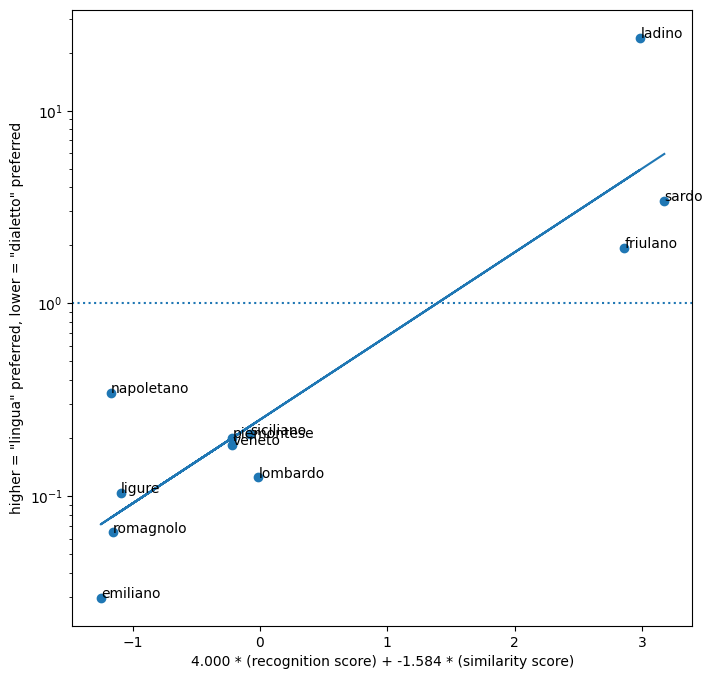

In [323]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yscale("log")
ax.axhline(y=1, linestyle=':')
ax.set_ylabel("higher = \"lingua\" preferred, lower = \"dialetto\" preferred")

x = a * recognition_scores + b * intelligibility_scores[recognition_scores.index]
y = ratios_df[::-1].iloc[0][recognition_scores.index]

ax.scatter(x, y)
for l in recognition_scores.index:
    ax.annotate(l, (x[l] + 0.003, y[l]))

best_fit_line = np.poly1d(np.polyfit(x, np.log(y), 1))
MSE = np.mean(np.square(best_fit_line(x) - np.log(y)))
print('log y = ' + str(best_fit_line).strip() + ' (mean square log error = ' + str(MSE) + ')')
ax.plot(x, np.exp(np.poly1d(best_fit_line)(x)))
_ = ax.set_xlabel(f"{a:.3f} * (recognition score) + {b:.3f} * (similarity score)")

Based on these coefficients, we can infer that the recognition score contributes about 2.5x more to the `lingua/dialetto` ratio than does the intelligibility score. It's probably safe to conclude that official recognition of a language makes an impact!

### Conclusion

So, what separates a language from a dialect, in the end?

We've learned quite a bit from exploring this data:

* There are huge discrepancies between different Romance language groups in Italy in terms of recognition as `lingue` rather than `dialetti` – compare, for example, the Rhaeto-Romance group and the Gallo-Italic group.
* Regional languages as a whole in Italy lost their `lingua` status fairly quickly in the Unification era, and spent the whole 20th century slowly getting it back.
* While there is some correlation between languages' `lingua/dialetto` ratio and their dissimilarity from Standard Italian, a much bigger causal factor is the level of official recognition that the language has within Italy.

Perhaps most interestingly, we've seen how fluid the distinction between languages and dialects can be – what is broadly considered a `dialetto` one year may be solidly referred to as `lingua` only a few decades later.